In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PetThermoTools as M
import Thermobar as pt
import PySulfSat as ss

import sys
sys.path.append(r"/Users/gleesonm/Library/CloudStorage/GoogleDrive-gleesonm@berkeley.edu/My Drive/2022/GitHub/PetThermoTools/MELTS")

M.__version__

'0.2.3'

In [2]:
from pyrolite.util.classification import TAS
from pyrolite.util.synthetic import normal_frame, random_cov_matrix

In [4]:
# used to suppress MELTS outputs in MacOS systems (run twice)
import os
sys.stdout = open(os.devnull, 'w')
sys.stderr = open(os.devnull, 'w')

In [14]:
starting_comp = {'SiO2': 47.5,
                'TiO2': 2.29,
                'Al2O3': 16.4,
                'FeOt': 9.16,
                'MnO': 0.123,
                'MgO': 9.38,
                'CaO':11.6,
                'Na2O': 2.25,
                'K2O': 0.329,
                'P2O5': 0.257,
                'H2O': 0.5,
                'CO2': 0.4}

In [15]:
Isobaric_Xtal = M.isobaric_crystallisation(
    Model = "MELTSv1.2.0", bulk = starting_comp, find_liquidus = True,
    P_bar = np.array([500,1000,2000,4000]), T_end_C = 1000, dt_C = 5,
    fO2_buffer = "FMQ", fO2_offset = -1.0,
    Frac_solid = True, Frac_fluid = True,
    label = "pressure")

  0%|          | 0/1 [00:00<?, ?it/s]

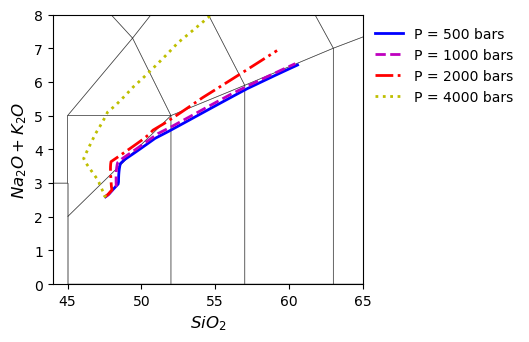

In [16]:
pressure = ['P = 500 bars', 'P = 1000 bars', 'P = 2000 bars', 'P = 4000 bars']
line = ['-', '--', '-.', ':']
color = ['b', 'm', 'r', 'y']

cm = TAS()
f, a = plt.subplots(1,1, figsize = (4,3.5))
cm.add_to_axes(a, alpha=0.5, linewidth=0.5, zorder=-1, add_labels=False)
for i in range(len(pressure)):
    Isobaric_Xtal[pressure[i]]['All']['Na2O + K2O'] = (Isobaric_Xtal[pressure[i]]['liquid1']['Na2O_Liq'] + 
                                                        Isobaric_Xtal[pressure[i]]['liquid1']['K2O_Liq'])
    Isobaric_Xtal[pressure[i]]['All'][["SiO2_Liq", "Na2O + K2O"]].pyroplot.plot(ax=a, color=color[i], 
                                                                    linestyle = line[i], linewidth = 2, alpha=1, 
                                                                    axlabels=False, label = pressure[i])

a.set_ylim([0, 8])
a.set_xlim([44, 65])
a.legend()

f.savefig("Pyrolite.svg", format='svg', dpi=1200)


Text(0, 0.5, 'FeO$_t$ (wt%)')

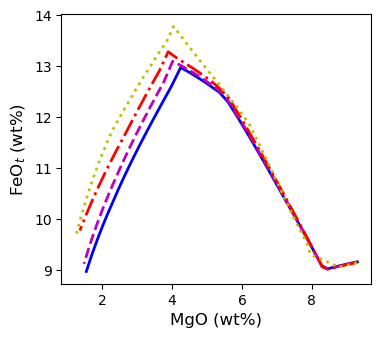

In [19]:
f, a = plt.subplots(1,1, figsize = (4, 3.5))
for i in range(len(pressure)):
    a.plot(Isobaric_Xtal[pressure[i]]['All']['MgO_Liq'],
           Isobaric_Xtal[pressure[i]]['All']['FeOt_Liq'], 
           ls = line[i], lw = 2, color = color[i])
    
a.set_xlabel('MgO (wt%)')
a.set_ylabel('FeO$_t$ (wt%)')

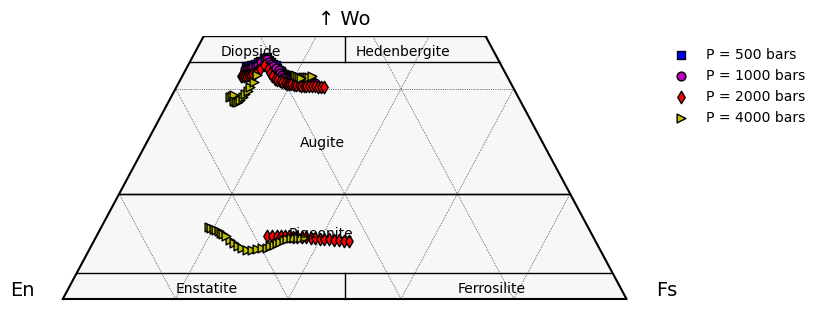

In [8]:
D = ['s', 'o', 'd', '>']

f, tax = pt.plot_px_classification(figsize = (8,3.5),
                                    major_grid = True,
                                    labels = True)

for i in range(len(pressure)):
    cpx_comps_tern_1 = pt.tern_points_px(px_comps = Isobaric_Xtal[pressure[i]]['clinopyroxene1'])
    if "clinopyroxene2" in Isobaric_Xtal[pressure[i]].keys():
        Cpx2 = Isobaric_Xtal[pressure[i]]['clinopyroxene2'].copy()
        Cpx2.columns = Cpx2.columns.str.replace('_Cpx2', '_Cpx')
        
        cpx_comps_tern_2 = pt.tern_points_px(px_comps = Cpx2)

    tax.scatter(cpx_comps_tern_1,
                edgecolor = 'k',
                marker = D[i],
                facecolor = color[i],
                s = 40,
                label = pressure[i])

    if "clinopyroxene2" in Isobaric_Xtal[pressure[i]].keys():
        tax.scatter(cpx_comps_tern_2,
                edgecolor = 'k',
                marker = D[i],
                facecolor = color[i],
                s = 40)

tax.legend()

f.savefig("Thermobar.svg", format='svg', dpi=1200)

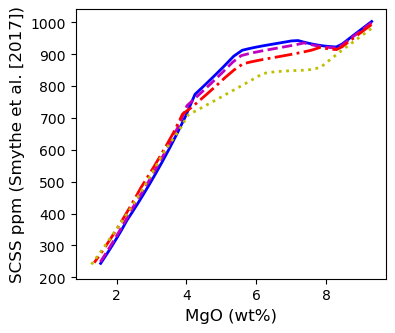

In [20]:
# save SCSS outputs calculated using Smythe et al. 2017
S2017_SCSS = {}
for i in Isobaric_Xtal:
    S2017_SCSS[i] = ss.calculate_S2017_SCSS(
        df=Isobaric_Xtal[i]['All'], T_K=Isobaric_Xtal[i]['All']['T_C']+273.15, 
        P_kbar=Isobaric_Xtal[i]['All']['P_bar']/1000, 
        Fe_FeNiCu_Sulf=0.6, Fe3Fet_Liq=Isobaric_Xtal[i]['All']['Fe3Fet_Liq'])

f, a = plt.subplots(1,1, figsize = (4, 3.5))
for i in range(len(pressure)):
    a.plot(Isobaric_Xtal[pressure[i]]['All']['MgO_Liq'],
            S2017_SCSS[pressure[i]]['SCSS2_ppm_ideal_Smythe2017'],
            line[i], lw = 2, c = color[i])

a.set_ylabel('SCSS ppm (Smythe et al. [2017])')
a.set_xlabel('MgO (wt%)')

f.savefig("PySulf.svg", format='svg', dpi=1200)


In [6]:
H2O_Liq = np.array([0.2, 0.5, 1, 2, 4])
CO2_Liq = np.array([0, 0.05, 0.1, 0.2, 0.4])
Fe3Fet_Liq = np.array([0.08, 0.11, 0.14, 0.17, 0.20])
P_bar = np.array([500,1000,2000,3000,4000])

meshgrid = np.meshgrid(H2O_Liq, CO2_Liq, Fe3Fet_Liq, P_bar, indexing='ij')

# Stack the arrays to get a 4 by n matrix
result_matrix = np.stack(meshgrid, axis=-1).reshape(-1, 4)

H2O_new = result_matrix[:,0]
CO2_new = result_matrix[:,1]
Fe3Fet_new = result_matrix[:,2]
P_new = result_matrix[:,3]

In [7]:
Isobaric_Xtal = M.isobaric_crystallisation(
    Model = "MELTSv1.2.0", bulk = starting_comp, find_liquidus = True,
    P_bar = P_new, T_end_C = 1000, dt_C = 5,
    Fe3Fet_Liq = Fe3Fet_new, H2O_Liq = H2O_new, CO2_Liq = CO2_new,
    Frac_solid = True, Frac_fluid = True,
    label = "pressure", timeout = 10)

  0%|          | 0/79 [00:00<?, ?it/s]

In [8]:
Isobaric_Xtal = M.multi_path(
    Model = "MELTSv1.2.0", bulk = starting_comp, find_liquidus = True, cores = 4,
    P_bar = P_new, T_end_C = 1000, dt_C = 5,
    Fe3Fet_Liq = Fe3Fet_new, H2O_Liq = H2O_new, CO2_Liq = CO2_new,
    Frac_solid = True, Frac_fluid = True,
    label = "pressure", timeout = 10)

  0%|          | 0/157 [00:00<?, ?it/s]

In [9]:
Isobaric_Xtal = M.multi_path(
    Model = "MELTSv1.2.0", bulk = starting_comp, find_liquidus = True, cores = 1,
    P_bar = P_new, T_end_C = 1000, dt_C = 5,
    Fe3Fet_Liq = Fe3Fet_new, H2O_Liq = H2O_new, CO2_Liq = CO2_new,
    Frac_solid = True, Frac_fluid = True,
    label = "pressure", timeout = 10)

  0%|          | 0/625 [00:00<?, ?it/s]

In [10]:
8.58/6.32

1.3575949367088607

In [11]:
24.04/8.58

2.801864801864802

In [12]:
24.04/6.32

3.8037974683544302

In [13]:
76.23/9.27

8.223300970873787

In [21]:
!pip install mineralML

In [22]:
import mineralML

In [23]:
mineralML.__version__

'0.0.0.1'

ModuleNotFoundError: No module named 'chemMap'